In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

2025-04-05 20:34:39.807614: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 20:34:39.820347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743885279.835480    2741 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743885279.840274    2741 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743885279.851380    2741 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
segmentation_model = load_model('/teamspace/studios/this_studio/best_unetmodel.keras', compile=False)
classifier_model = load_model('/teamspace/studios/this_studio/brain_tumor_classifier.keras') 

2025-04-05 20:34:41.727007: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [4]:
image_folder = '/teamspace/studios/this_studio/test_data' 
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]


Processing test_1.jpg...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


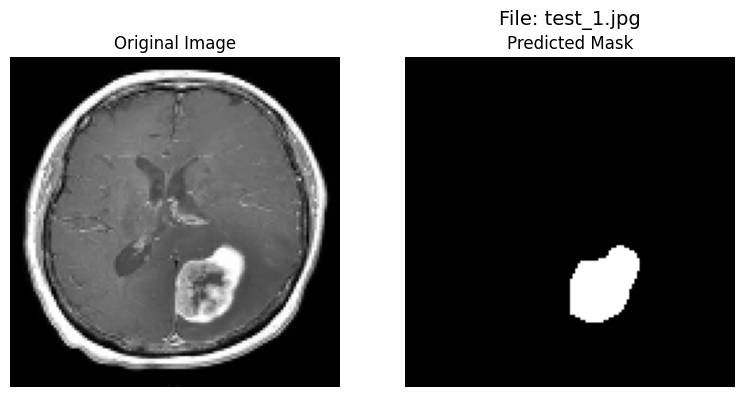

Predicted Class: glioma_tumor

Processing test_2.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


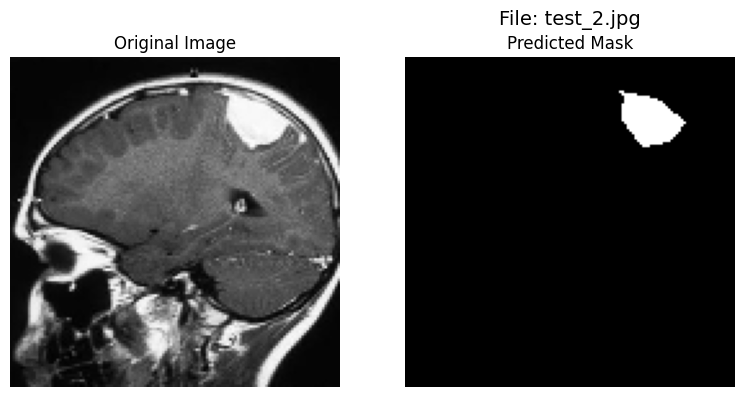

Predicted Class: meningioma_tumor

Processing test_3.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


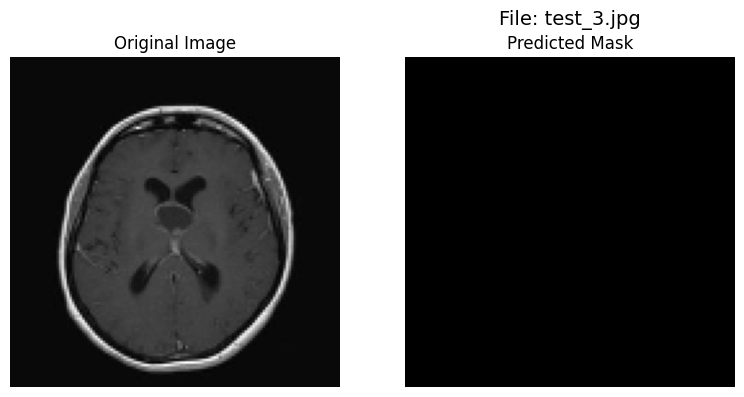

Predicted Class: no_tumor

Processing test_4.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


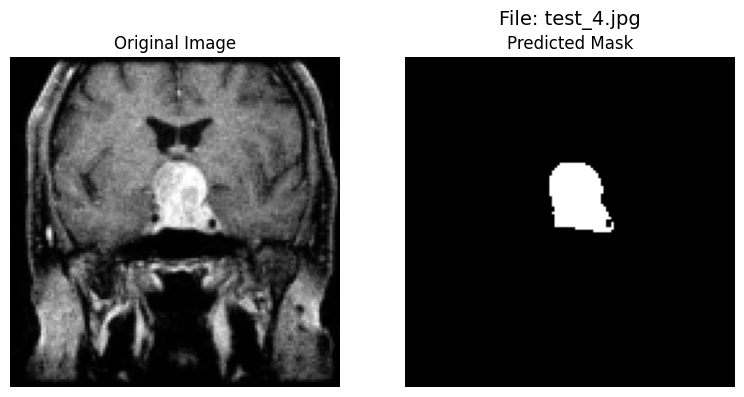

Predicted Class: pituitary_tumor


In [5]:
for idx, file_name in enumerate(image_files):
    print(f"\nProcessing {file_name}...")
    
    image_path = os.path.join(image_folder, file_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, (128, 128))
    normalized_image = image_resized / 255.0
    input_for_unet = np.expand_dims(normalized_image, axis=(0, -1)) 

    # --- Predict Mask ---
    predicted_mask = segmentation_model.predict(input_for_unet)[0]
    binary_mask = (predicted_mask > 0.5).astype(np.uint8).squeeze()

    resized_crop = cv2.resize(binary_mask, (150, 150))

    # --- Prepare Input for Classifier ---
    input_for_classifier = np.expand_dims(resized_crop, axis=(0, -1)) 
    input_for_classifier = np.repeat(input_for_classifier, 3, axis=-1) 

    # --- Predict Tumor Class ---
    prediction = classifier_model.predict(input_for_classifier)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]

    # --- Display Results ---
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(normalized_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.suptitle(f"File: {file_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"Predicted Class: {predicted_class_name}")